In [3]:

# Predicting Locational Based Marginal Pricing (LBMP) given 6 day Load forcast for 12 Zone in the NewYork City
# By: Mehrshad Mehboudi



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

In [3]:
# Issues in load forcasting
# short forcast (24hrs)
# longer forcast (1 week)
# model selection, Regression, Time series, SVR, Random Forest etc,
# optimization of hyper parameters


In [4]:
damlbmp_zone_files =[] # The day ahead expected prices per Megawatt/Hour by zone every hours
damlbmp_zone_files =['2021020{}damlbmp_zone.csv'.format(i) for i in range(1,10)]
damlbmp_zone_files.extend( ['202102{}damlbmp_zone.csv'.format(i) for i in range(10,29)])
frames = [ pd.read_csv(f) for f in damlbmp_zone_files ]
damlbmp_zone = pd.concat(frames)

In [5]:
# Let's create a list of isolf files names
isolf_files =[]   # The load the ISO was forecasting for the grid in Megawatts every hours
isolf_files =['2021020{}isolf.csv'.format(i) for i in range(1,10)]
isolf_files.extend( ['202102{}isolf.csv'.format(i) for i in range(10,29)])

In [6]:
sample_isolf = pd.read_csv(isolf_files[0])

In [7]:
#General info
sample_isolf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 13 columns):
Time Stamp    144 non-null object
Capitl        144 non-null int64
Centrl        144 non-null int64
Dunwod        144 non-null int64
Genese        144 non-null int64
Hud Vl        144 non-null int64
Longil        144 non-null int64
Mhk Vl        144 non-null int64
Millwd        144 non-null int64
N.Y.C.        144 non-null int64
North         144 non-null int64
West          144 non-null int64
NYISO         144 non-null int64
dtypes: int64(12), object(1)
memory usage: 14.8+ KB


In [8]:
sample_isolf.head()

Time Stamp  Capitl  Centrl  Dunwod  Genese  Hud Vl  Longil  Mhk Vl  \
0  02/01/2021 00:00    1406    1753     588    1026    1034    2007     857   
1  02/01/2021 01:00    1386    1738     570    1009    1002    1928     836   
2  02/01/2021 02:00    1381    1723     556    1005     989    1878     836   
3  02/01/2021 03:00    1379    1734     550    1010     997    1863     841   
4  02/01/2021 04:00    1406    1780     556    1035    1007    1898     857   

   Millwd  N.Y.C.  North  West  NYISO  
0     324    5017    676  1577  16265  
1     320    4848    674  1560  15871  
2     312    4729    675  1555  15639  
3     300    4666    671  1558  15569  
4     312    4699    677  1587  15814

In [9]:
# reading the first isolf file and reshaping it
col=sample_isolf.columns
new_frame= pd.read_csv(isolf_files[0]).values.reshape(6,312)
frames = [ pd.DataFrame(new_frame[i,:].reshape(24,13)) for i in range(0,6) ]
all_frames = pd.concat(frames, axis=1)
isolf1 = all_frames

In [10]:
# reading all other files for all days of February
for file in isolf_files[1:len(isolf_files)]:
    new_frame= pd.read_csv(file).values.reshape(6,312)
    frames = [ pd.DataFrame(new_frame[i,:].reshape(24,13)) for i in range(0,6) ]
    all_frames = pd.concat(frames, axis=1)
    isolf1 = isolf1.append(all_frames, ignore_index=True)
    

In [11]:
isolf1.shape  # there are 28 days and 24 hours so 24*28 =672 rows
              # there are 12 zones and each one has 6 days ahead predictions we keep all of them 6*12 =72 and 6 
              # redundant columns correspond to Time Stamps which later on, only one will be kept

(672, 78)

In [12]:
isolf1.head()  # we need to rename the column names

0     1     2    3     4     5     6    7    8     9   ...  \
0  02/01/2021 00:00  1406  1753  588  1026  1034  2007  857  324  5017  ...   
1  02/01/2021 01:00  1386  1738  570  1009  1002  1928  836  320  4848  ...   
2  02/01/2021 02:00  1381  1723  556  1005   989  1878  836  312  4729  ...   
3  02/01/2021 03:00  1379  1734  550  1010   997  1863  841  300  4666  ...   
4  02/01/2021 04:00  1406  1780  556  1035  1007  1898  857  312  4699  ...   

    3    4    5     6    7    8     9    10    11     12  
0  511  951  915  1835  729  287  4696  606  1521  14808  
1  488  929  882  1752  706  282  4529  597  1492  14366  
2  473  916  863  1707  693  280  4415  593  1471  14089  
3  469  913  862  1681  689  274  4346  594  1462  13966  
4  472  919  867  1691  696  277  4333  593  1471  14011  

[5 rows x 78 columns]

In [13]:
col_names=[]
for i in range(0,6):
    col_names[i*13:i*13+13]=[col[j]+'_'+str(i) for j in range(0,13)]

In [14]:
col_names

['Time Stamp_0',
 'Capitl_0',
 'Centrl_0',
 'Dunwod_0',
 'Genese_0',
 'Hud Vl_0',
 'Longil_0',
 'Mhk Vl_0',
 'Millwd_0',
 'N.Y.C._0',
 'North_0',
 'West_0',
 'NYISO_0',
 'Time Stamp_1',
 'Capitl_1',
 'Centrl_1',
 'Dunwod_1',
 'Genese_1',
 'Hud Vl_1',
 'Longil_1',
 'Mhk Vl_1',
 'Millwd_1',
 'N.Y.C._1',
 'North_1',
 'West_1',
 'NYISO_1',
 'Time Stamp_2',
 'Capitl_2',
 'Centrl_2',
 'Dunwod_2',
 'Genese_2',
 'Hud Vl_2',
 'Longil_2',
 'Mhk Vl_2',
 'Millwd_2',
 'N.Y.C._2',
 'North_2',
 'West_2',
 'NYISO_2',
 'Time Stamp_3',
 'Capitl_3',
 'Centrl_3',
 'Dunwod_3',
 'Genese_3',
 'Hud Vl_3',
 'Longil_3',
 'Mhk Vl_3',
 'Millwd_3',
 'N.Y.C._3',
 'North_3',
 'West_3',
 'NYISO_3',
 'Time Stamp_4',
 'Capitl_4',
 'Centrl_4',
 'Dunwod_4',
 'Genese_4',
 'Hud Vl_4',
 'Longil_4',
 'Mhk Vl_4',
 'Millwd_4',
 'N.Y.C._4',
 'North_4',
 'West_4',
 'NYISO_4',
 'Time Stamp_5',
 'Capitl_5',
 'Centrl_5',
 'Dunwod_5',
 'Genese_5',
 'Hud Vl_5',
 'Longil_5',
 'Mhk Vl_5',
 'Millwd_5',
 'N.Y.C._5',
 'North_5',
 'West_5'

In [15]:
len(col_names)

78

In [16]:
isolf1.columns =col_names

In [17]:
isolf1.drop(columns= ['Time Stamp_1','Time Stamp_2','Time Stamp_3','Time Stamp_4','Time Stamp_5'], inplace=True)

In [18]:
isolf1.shape

(672, 73)

In [19]:
# Checking for missing data , There is no missing data
isolf1.isna().sum().sort_values(ascending=False)[:20] 

NYISO_5     0
West_2      0
Mhk Vl_1    0
Millwd_1    0
N.Y.C._1    0
North_1     0
West_1      0
NYISO_1     0
Capitl_2    0
Centrl_2    0
Dunwod_2    0
Genese_2    0
Hud Vl_2    0
Longil_2    0
Mhk Vl_2    0
Millwd_2    0
N.Y.C._2    0
Longil_1    0
Hud Vl_1    0
Genese_1    0
dtype: int64

In [20]:
# Visualizing the effect of different features on the target

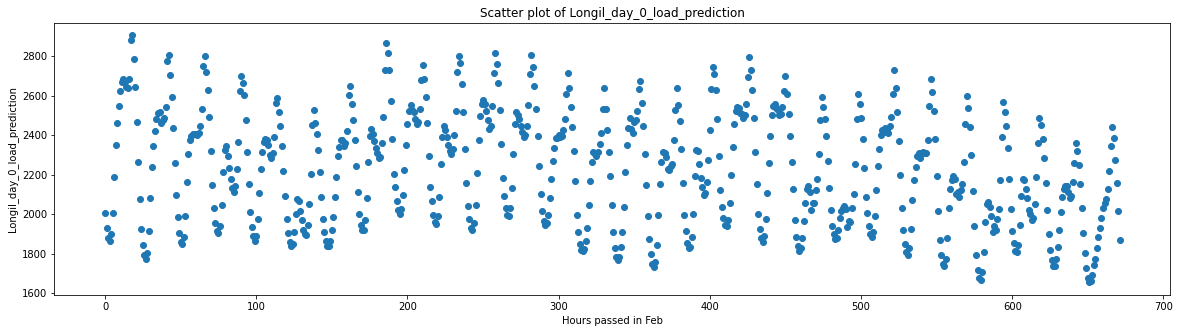

In [21]:
plt.figure(figsize=(20,5))
plt.scatter(isolf1.index,isolf1.Longil_0)
plt.title('Scatter plot of Longil_day_0_load_prediction')
plt.ylabel('Longil_day_0_load_prediction')
plt.xlabel('Hours passed in Feb')
plt.show()


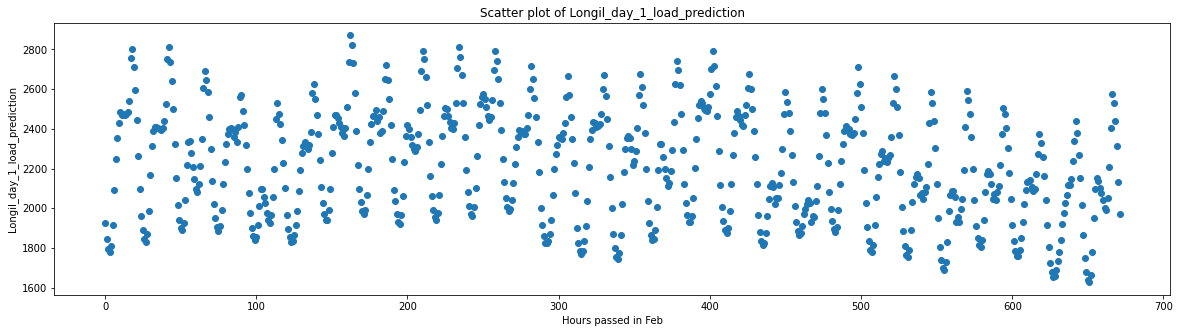

In [22]:
plt.figure(figsize=(20,5))
plt.scatter(isolf1.index,isolf1.Longil_1)
plt.title('Scatter plot of Longil_day_1_load_prediction')
plt.ylabel('Longil_day_1_load_prediction')
plt.xlabel('Hours passed in Feb')
plt.show()

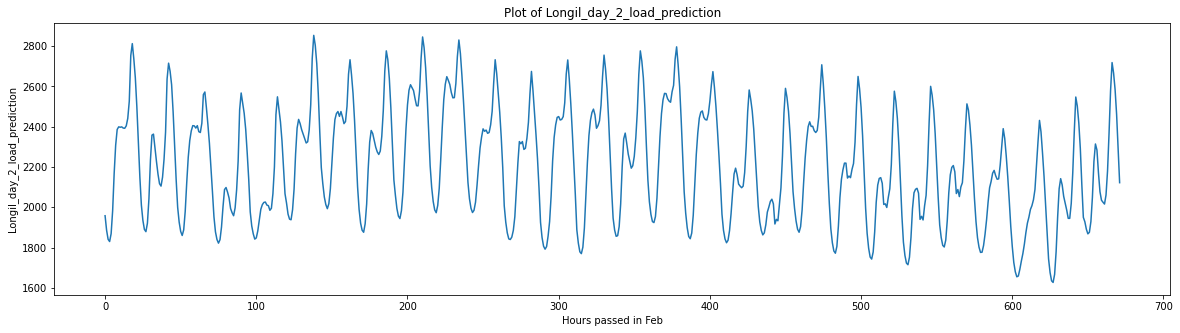

In [23]:
plt.figure(figsize=(20,5))
plt.plot(isolf1.index,isolf1.Longil_2)
plt.title('Plot of Longil_day_2_load_prediction')
plt.ylabel('Longil_day_2_load_prediction')
plt.xlabel('Hours passed in Feb')
plt.show()

In [24]:
Y=damlbmp_zone[damlbmp_zone['Name'] == 'LONGIL']


In [25]:
Y.reset_index(drop=True , inplace=True)

In [26]:
Y

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0    02/01/2021 00:00  LONGIL  61762          99.68   
1    02/01/2021 01:00  LONGIL  61762          95.00   
2    02/01/2021 02:00  LONGIL  61762          82.82   
3    02/01/2021 03:00  LONGIL  61762          83.83   
4    02/01/2021 04:00  LONGIL  61762          83.89   
..                ...     ...    ...            ...   
667  02/28/2021 19:00  LONGIL  61762          40.61   
668  02/28/2021 20:00  LONGIL  61762          36.06   
669  02/28/2021 21:00  LONGIL  61762          35.44   
670  02/28/2021 22:00  LONGIL  61762          34.17   
671  02/28/2021 23:00  LONGIL  61762          27.21   

     Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  
0                             1.23                             -87.93  
1                             0.94                             -85.47  
2                             0.74                             -75.31  
3                             0.85                             -75.08  
4                             1.14                             -72.26  
..                             ...                                ...  
667                           1.07                             -27.49  
668                           0.86                             -25.00  
669                           0.77                             -25.70  
670                           0.77                             -25.00  
671                           0.61                             -20.08  

[672 rows x 6 columns]

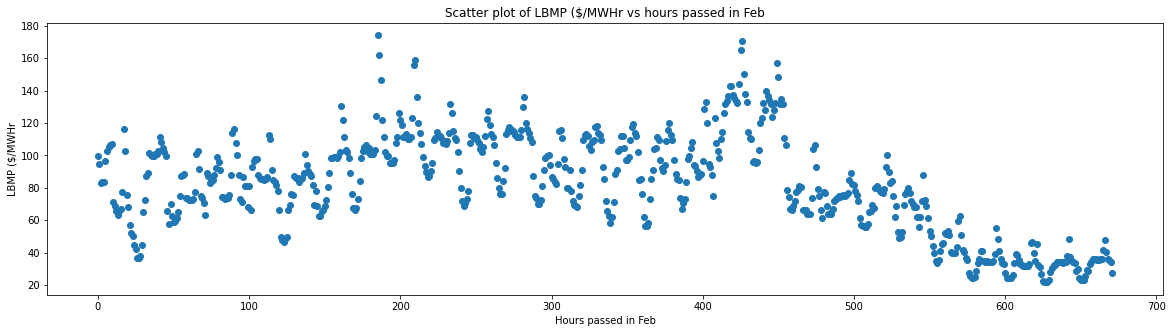

In [27]:
plt.figure(figsize=(20,5))
plt.scatter(Y.index, Y['LBMP ($/MWHr)'])
plt.title('Scatter plot of LBMP ($/MWHr vs hours passed in Feb')
plt.ylabel('LBMP ($/MWHr')
plt.xlabel('Hours passed in Feb')
plt.show()

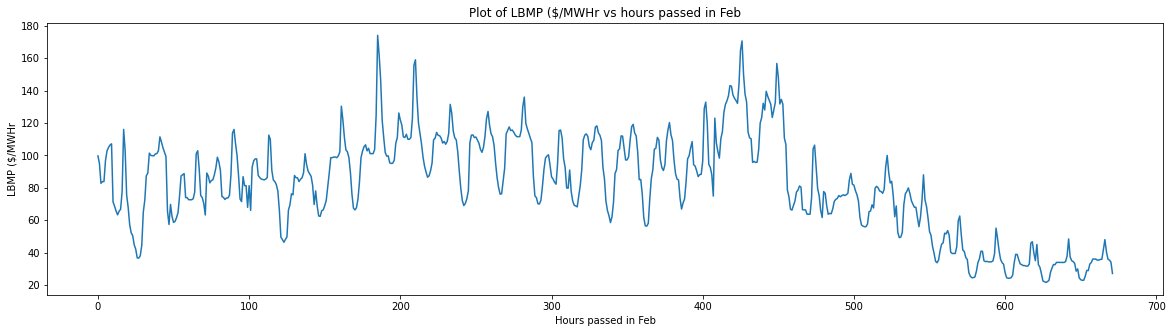

In [28]:
plt.figure(figsize=(20,5))
plt.plot(Y.index, Y['LBMP ($/MWHr)'])
plt.title('Plot of LBMP ($/MWHr vs hours passed in Feb')
plt.ylabel('LBMP ($/MWHr')
plt.xlabel('Hours passed in Feb')
plt.show()

In [29]:
Y

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0    02/01/2021 00:00  LONGIL  61762          99.68   
1    02/01/2021 01:00  LONGIL  61762          95.00   
2    02/01/2021 02:00  LONGIL  61762          82.82   
3    02/01/2021 03:00  LONGIL  61762          83.83   
4    02/01/2021 04:00  LONGIL  61762          83.89   
..                ...     ...    ...            ...   
667  02/28/2021 19:00  LONGIL  61762          40.61   
668  02/28/2021 20:00  LONGIL  61762          36.06   
669  02/28/2021 21:00  LONGIL  61762          35.44   
670  02/28/2021 22:00  LONGIL  61762          34.17   
671  02/28/2021 23:00  LONGIL  61762          27.21   

     Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  
0                             1.23                             -87.93  
1                             0.94                             -85.47  
2                             0.74                             -75.31  
3                             0.85                             -75.08  
4                             1.14                             -72.26  
..                             ...                                ...  
667                           1.07                             -27.49  
668                           0.86                             -25.00  
669                           0.77                             -25.70  
670                           0.77                             -25.00  
671                           0.61                             -20.08  

[672 rows x 6 columns]

In [30]:
X= isolf1.iloc[:, 0:73]

In [31]:
X['Time Stamp_0'] # from Time Stamp we extract hour and day as two new features
# the rest is not important

0      02/01/2021 00:00
1      02/01/2021 01:00
2      02/01/2021 02:00
3      02/01/2021 03:00
4      02/01/2021 04:00
             ...       
667    02/28/2021 19:00
668    02/28/2021 20:00
669    02/28/2021 21:00
670    02/28/2021 22:00
671    02/28/2021 23:00
Name: Time Stamp_0, Length: 672, dtype: object

In [32]:
 X[['Month','day' ,'hour' ,'min' ]]=X['Time Stamp_0'].str.split('/|:|" "' , expand =True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [33]:
X.head()

Time Stamp_0 Capitl_0 Centrl_0 Dunwod_0 Genese_0 Hud Vl_0 Longil_0  \
0  02/01/2021 00:00     1406     1753      588     1026     1034     2007   
1  02/01/2021 01:00     1386     1738      570     1009     1002     1928   
2  02/01/2021 02:00     1381     1723      556     1005      989     1878   
3  02/01/2021 03:00     1379     1734      550     1010      997     1863   
4  02/01/2021 04:00     1406     1780      556     1035     1007     1898   

  Mhk Vl_0 Millwd_0 N.Y.C._0  ... Mhk Vl_5 Millwd_5 N.Y.C._5 North_5 West_5  \
0      857      324     5017  ...      729      287     4696     606   1521   
1      836      320     4848  ...      706      282     4529     597   1492   
2      836      312     4729  ...      693      280     4415     593   1471   
3      841      300     4666  ...      689      274     4346     594   1462   
4      857      312     4699  ...      696      277     4333     593   1471   

  NYISO_5 Month day     hour min  
0   14808    02  01  2021 00  00  
1   14366    02  01  2021 01  00  
2   14089    02  01  2021 02  00  
3   13966    02  01  2021 03  00  
4   14011    02  01  2021 04  00  

[5 rows x 77 columns]

In [34]:
X[['year' , 'hours']] = X['hour'].str.split(expand =True)
X.drop(columns = ['Time Stamp_0' , 'hour', 'min' , 'year' , 'Month'] , inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
X =X.applymap(float ) # days and hour column are strings so we need to cinvert them into float

In [36]:
X.day

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
667    28.0
668    28.0
669    28.0
670    28.0
671    28.0
Name: day, Length: 672, dtype: float64

# Scaling the data

In [37]:
from sklearn.preprocessing import RobustScaler
scale = RobustScaler()
X = pd.DataFrame(data=scale.fit_transform(X), columns=X.columns)

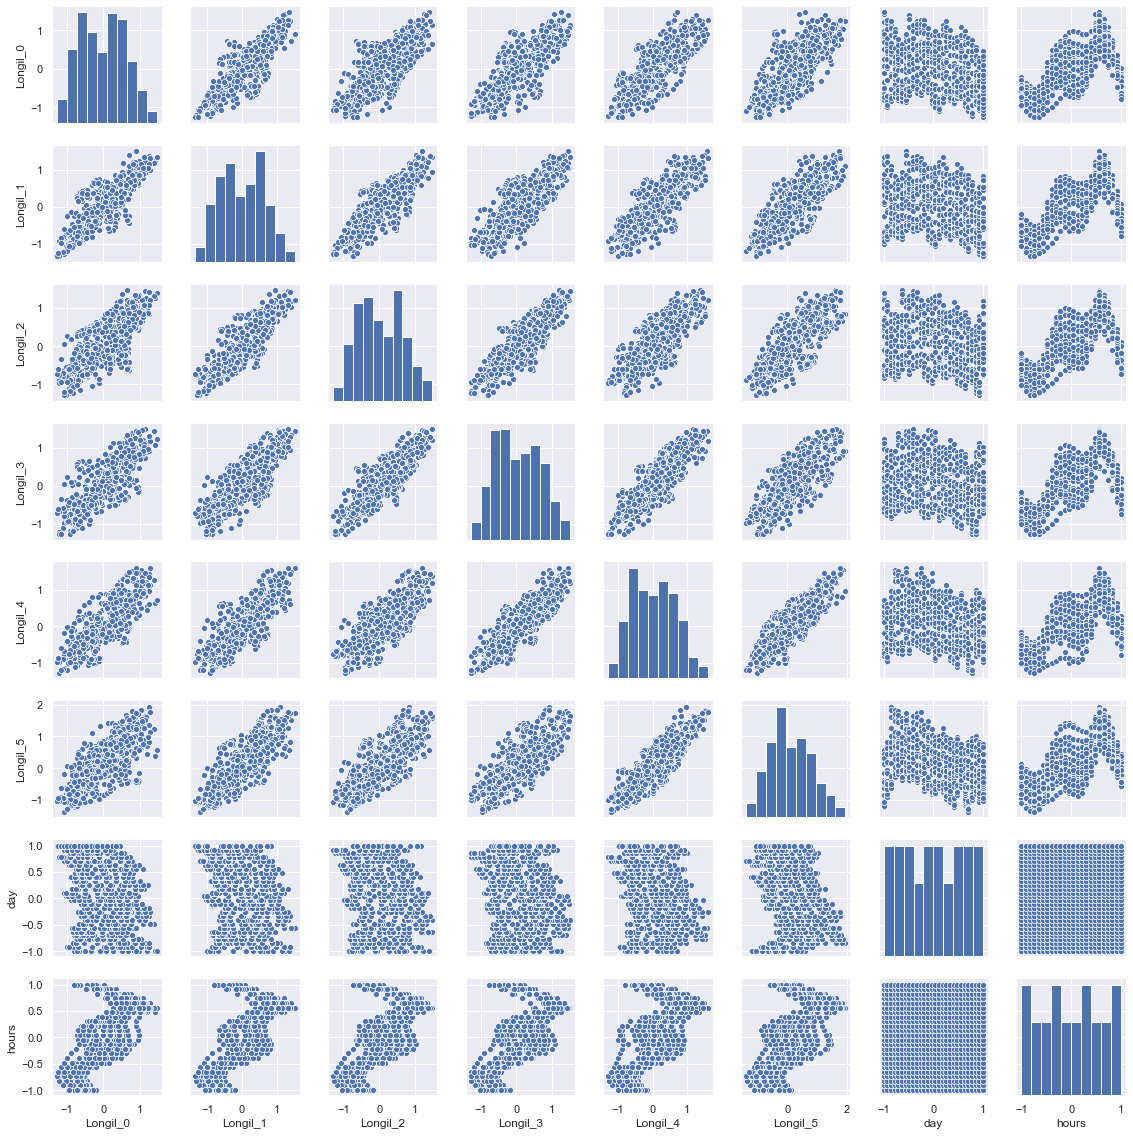

In [38]:
#scatterplot
sns.set()
cols = ['Longil_0', 'Longil_1', 'Longil_2', 'Longil_3', 'Longil_4', 'Longil_5', 'day', 'hours']
sns.pairplot(X[cols], height = 2.0)
plt.show();

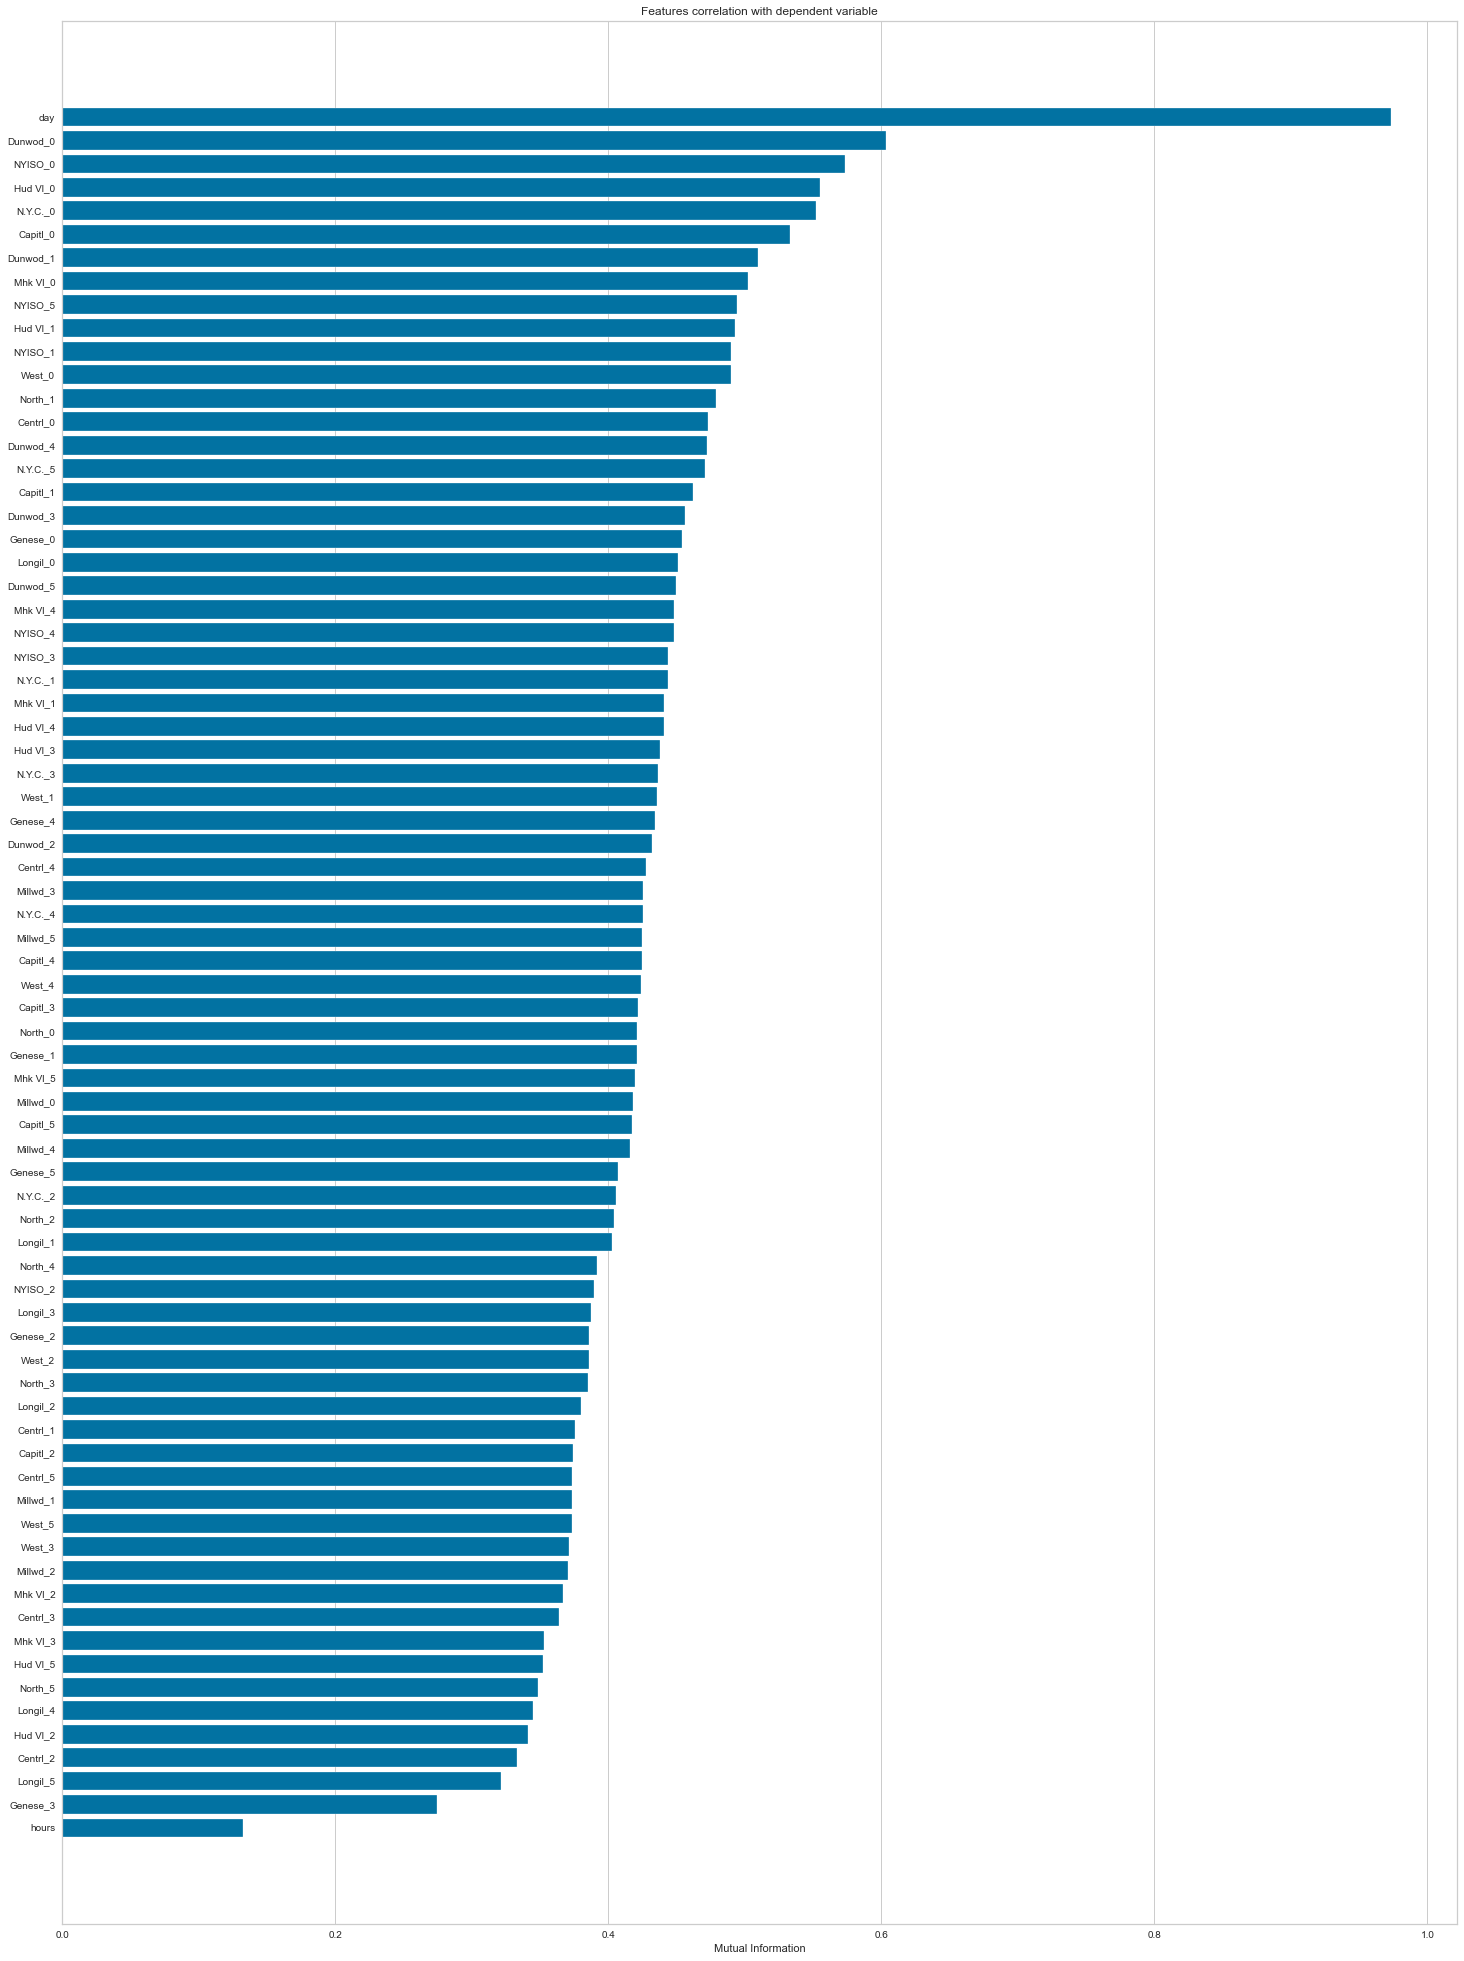

In [39]:
# Correlation as per Mutual Info Regression
from yellowbrick.target import FeatureCorrelation
plt.figure(figsize=(25,35))
viz = FeatureCorrelation(labels=X.columns, method='mutual_info-regression', sort=True)
viz.fit(X, Y['LBMP ($/MWHr)'])
viz.poof()
plt.show()

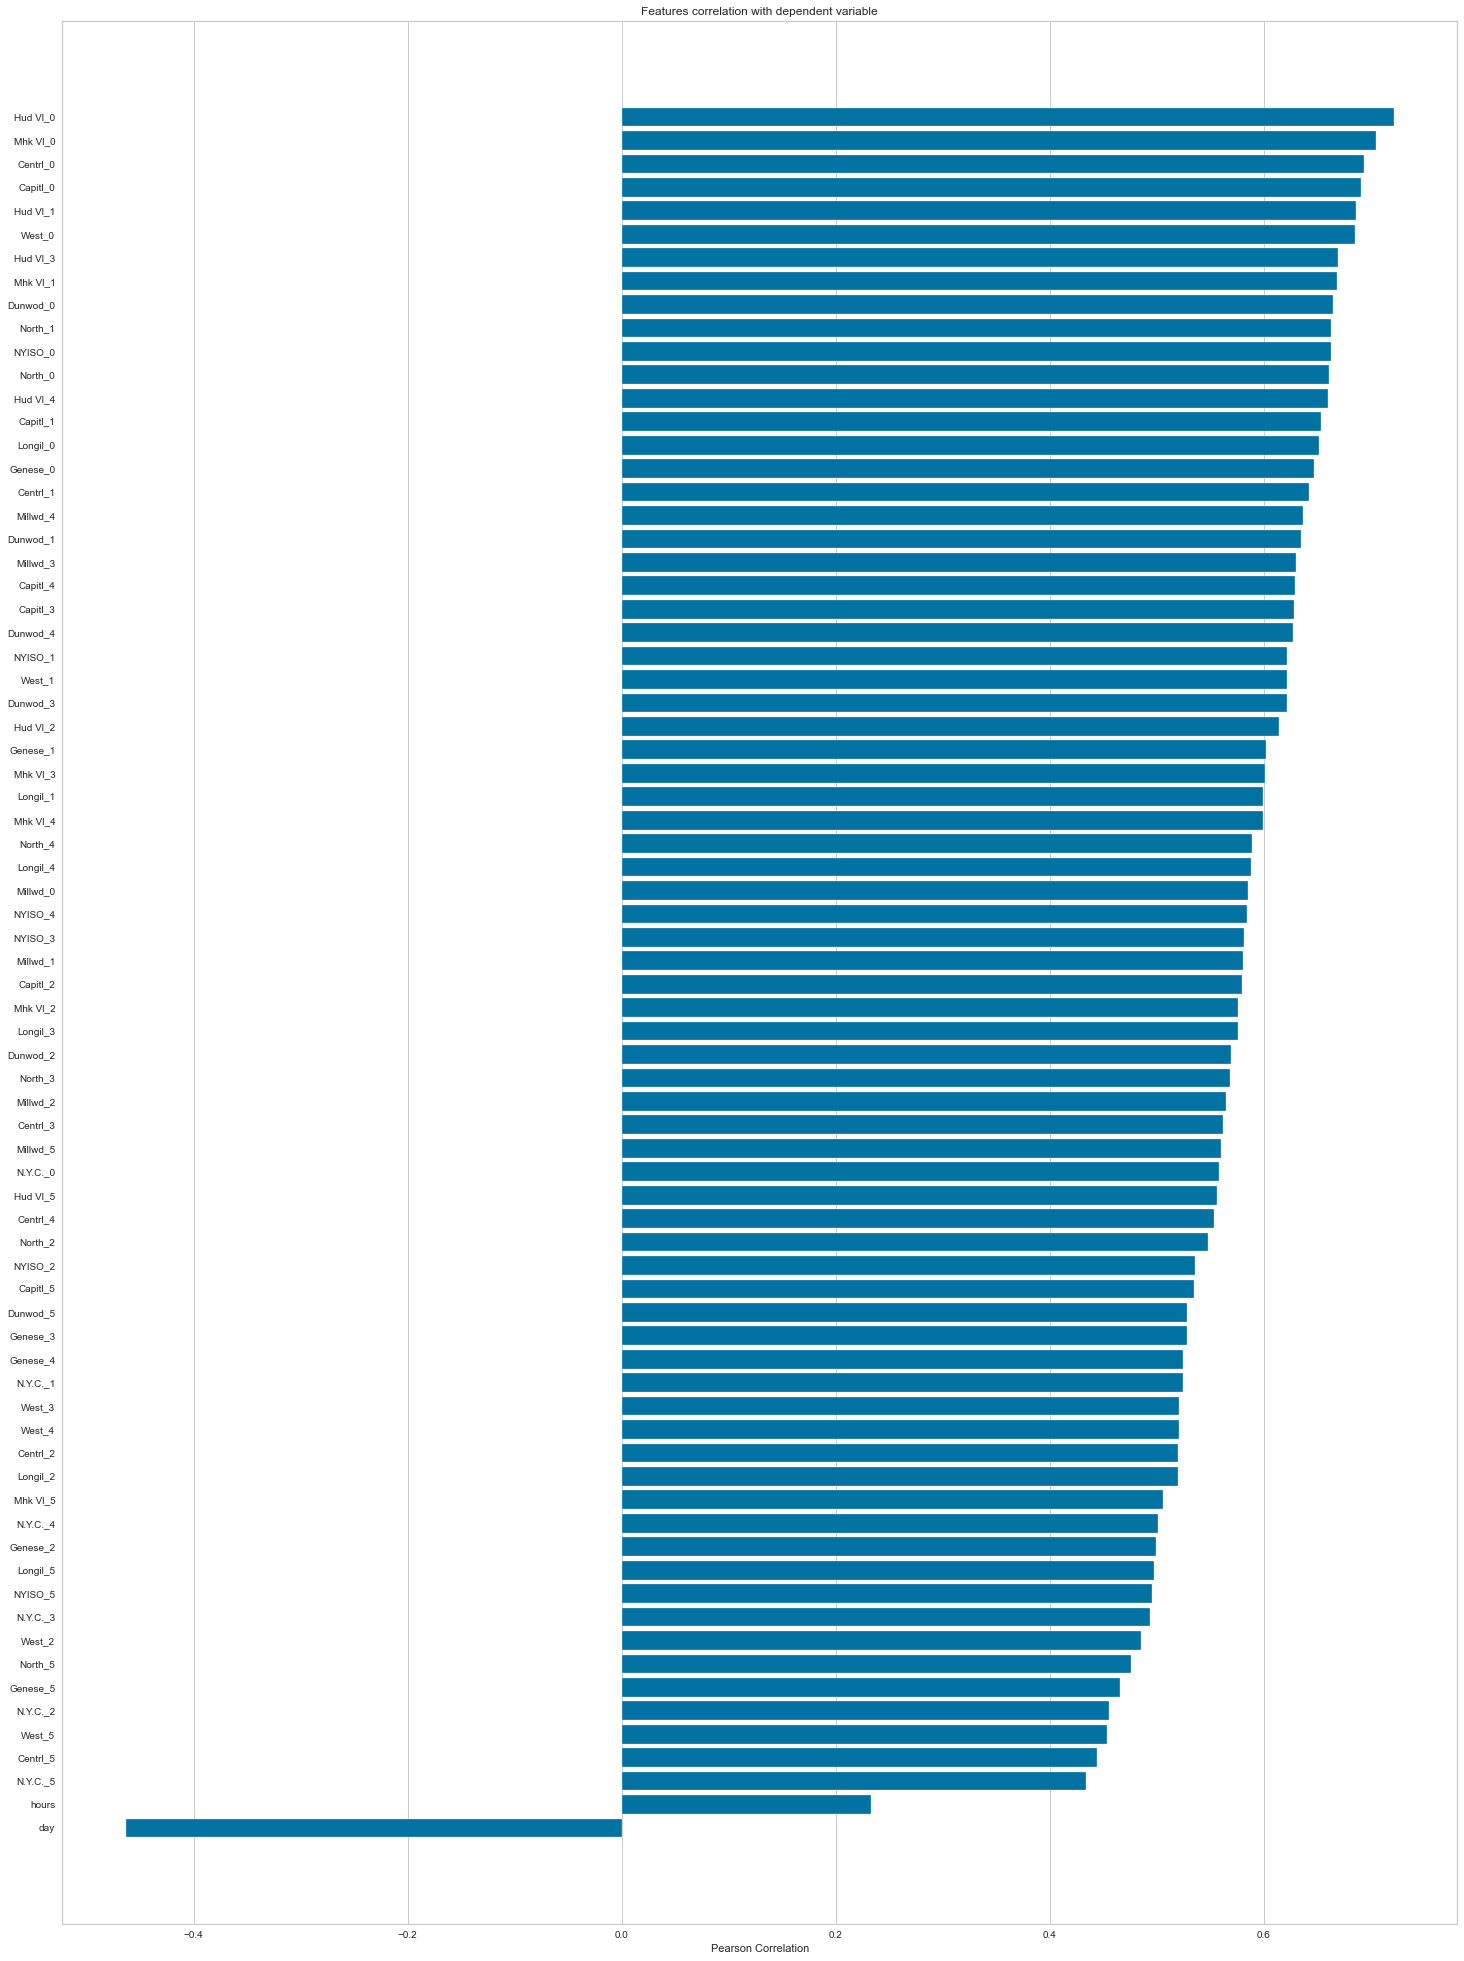

In [40]:
# Correlation as per Mutual Info Regression
plt.figure(figsize=(25,35))
viz = FeatureCorrelation(labels=X.columns, method='pearson', sort=True)
viz.fit(X, Y['LBMP ($/MWHr)'])
viz.poof()
plt.show()

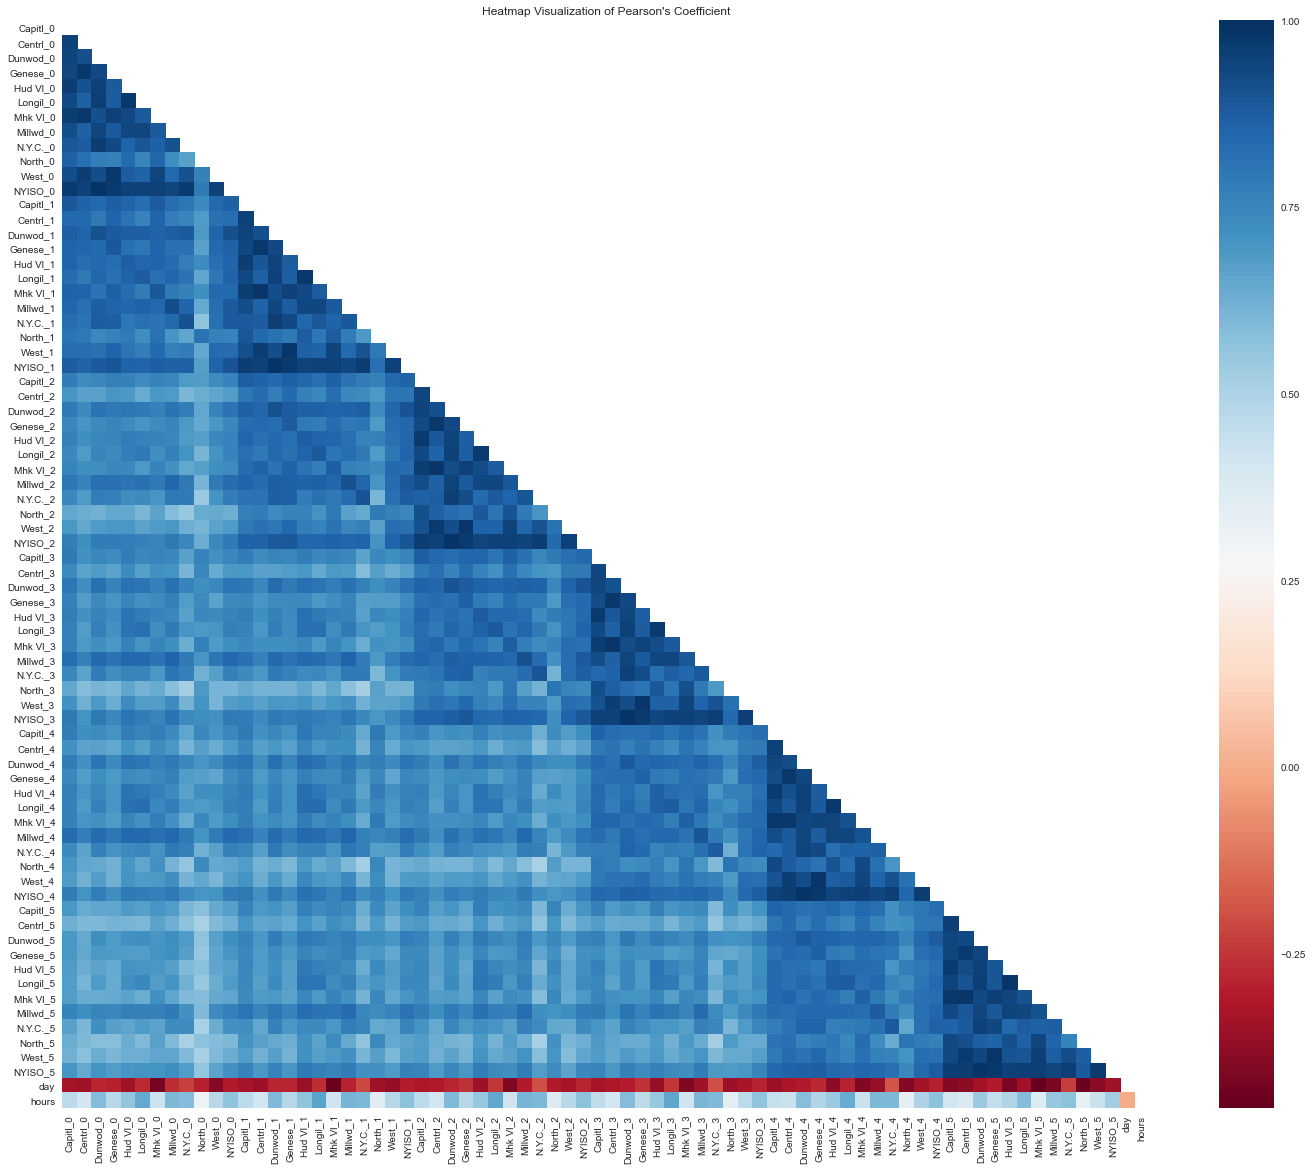

In [41]:
# Heatmap Visualization of Pearson's Coefficient
datacor = X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(datacor, dtype=np.bool))
plt.figure(figsize=(25,20))
sns.heatmap(datacor, mask=mask, annot=False, square=True, cmap='RdBu')
plt.title("Heatmap Visualization of Pearson's Coefficient")
plt.show()

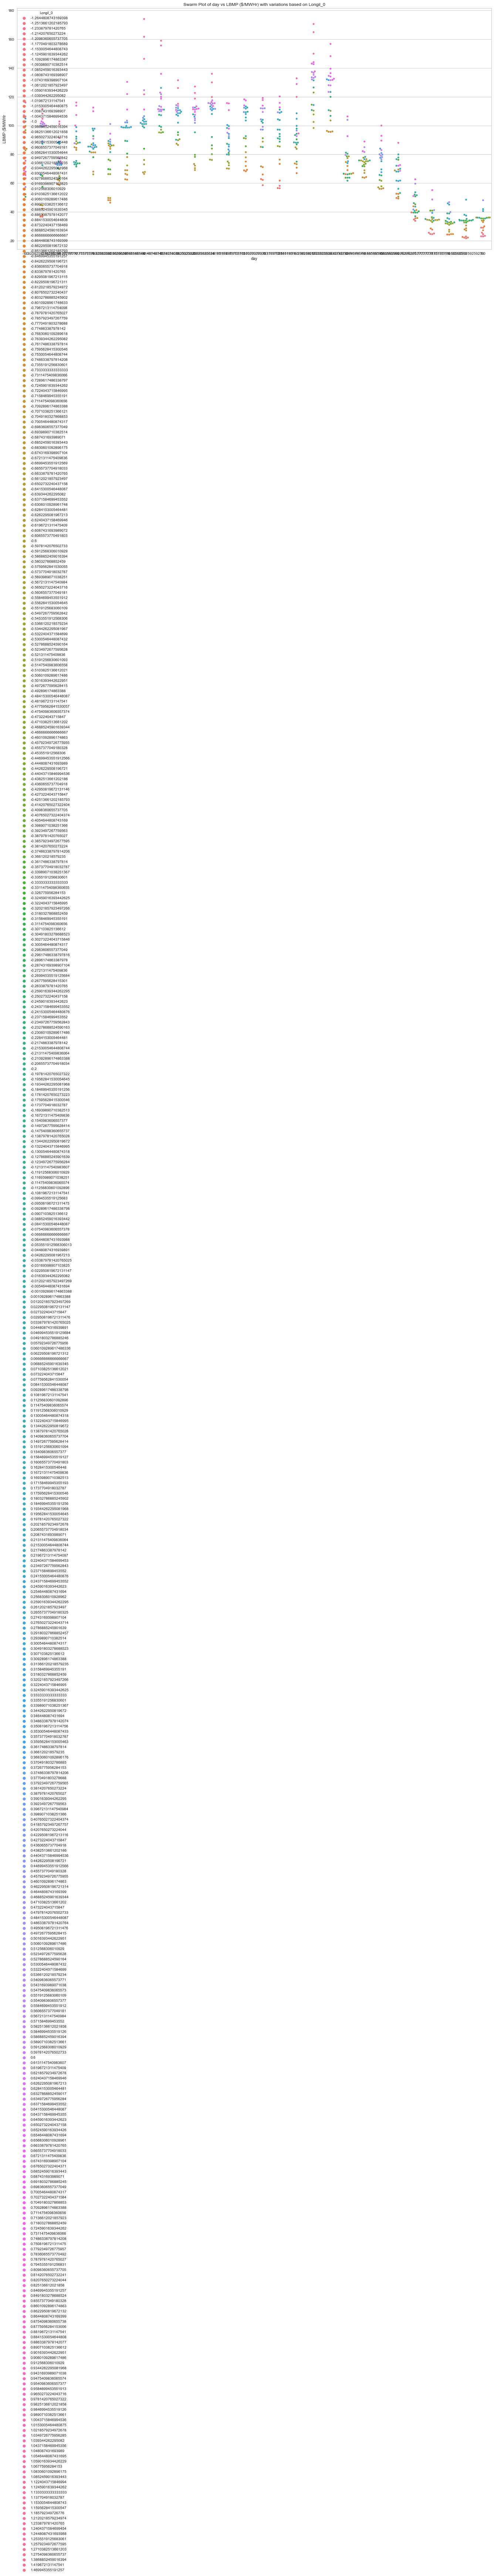

In [42]:
# Swarm Plot
plt.figure(figsize=(23,12))
sns.swarmplot(X['day'], Y['LBMP ($/MWHr)'], hue=X['Longil_0'], palette='husl')
plt.title("Swarm Plot of day vs LBMP ($/MWHr) with variations based on Longil_0")
plt.xlabel("day")
plt.ylabel("LBMP ($/MWHr")
plt.show()

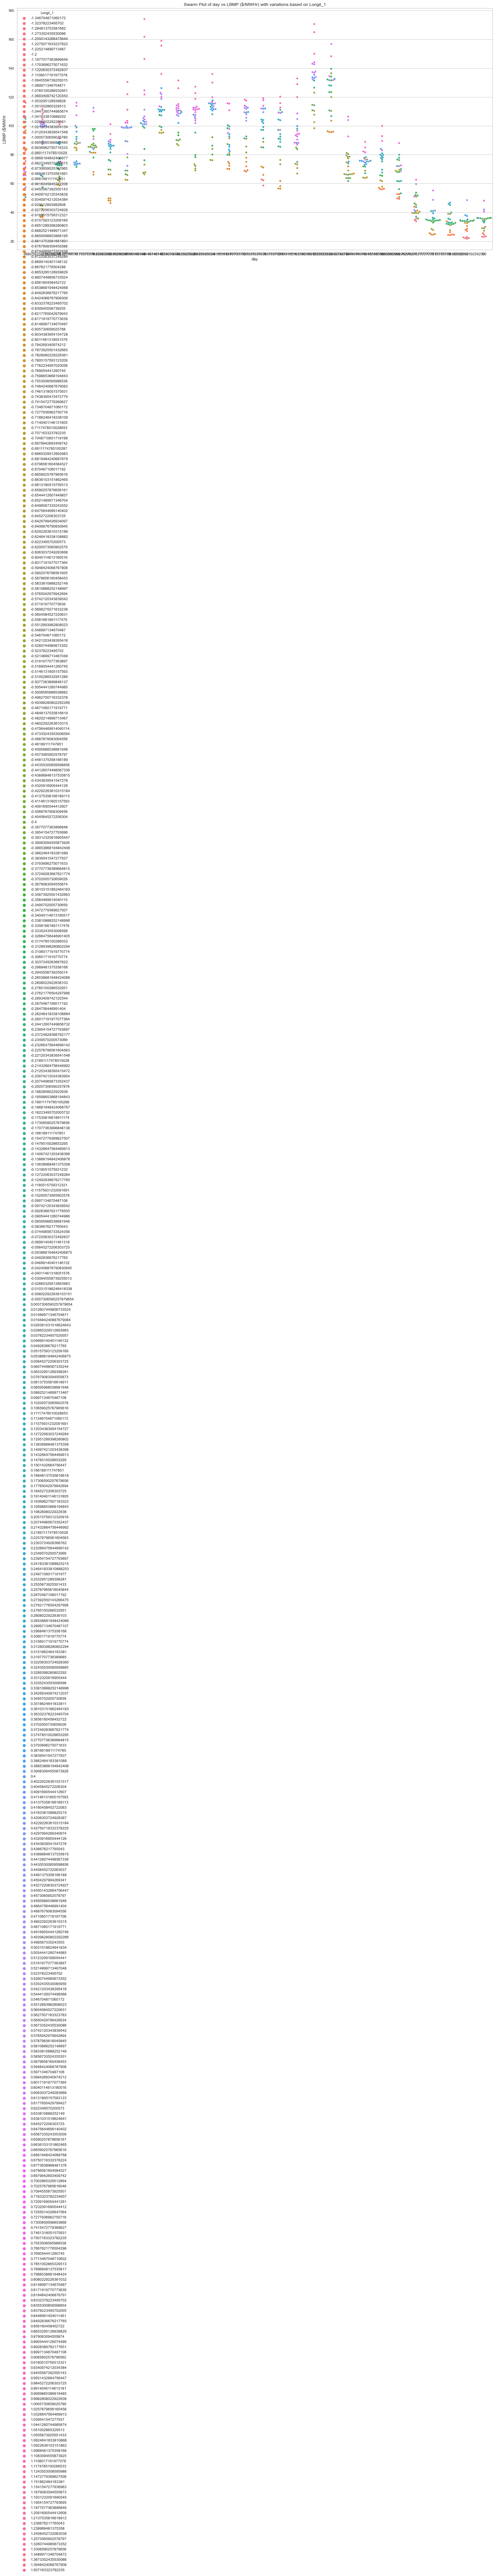

In [43]:
# Swarm Plot 
plt.figure(figsize=(23,12))
sns.swarmplot(X['day'], Y['LBMP ($/MWHr)'], hue=X['Longil_1'], palette='husl')
plt.title("Swarm Plot of day vs LBMP ($/MWHr) with variations based on Longil_1")
plt.xlabel("day")
plt.ylabel("LBMP ($/MWHr")
plt.show()

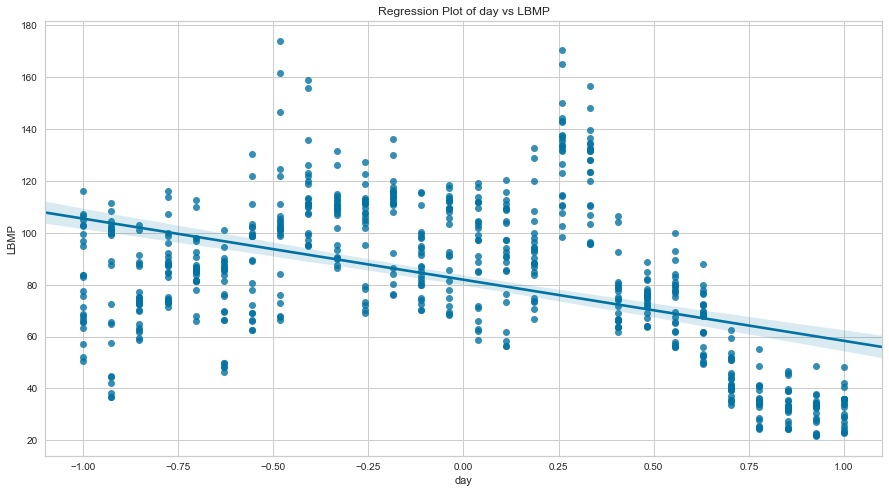

In [44]:
# Regression Plot day vs LBMP
plt.figure(figsize=(15,8))
sns.regplot(X['day'], Y['LBMP ($/MWHr)'])
plt.title("Regression Plot of day vs LBMP")
plt.xlabel("day")
plt.ylabel("LBMP")
plt.show()

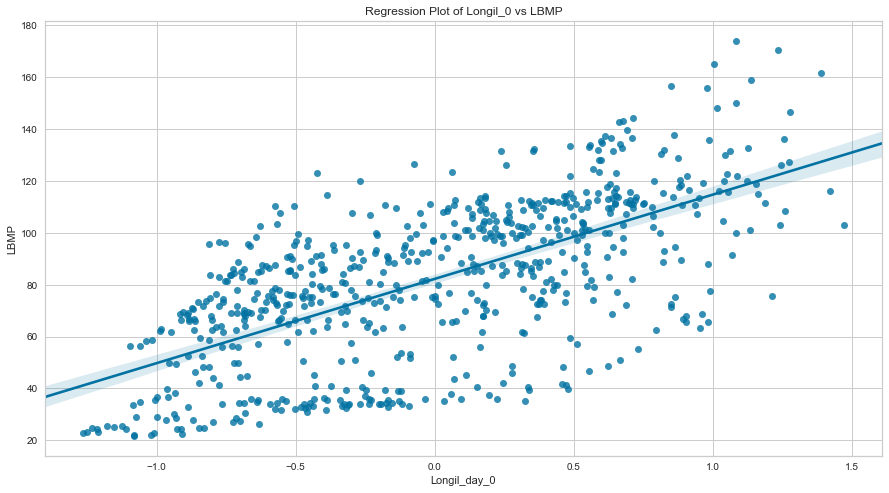

In [45]:
# Regression Plot day vs LBMP
plt.figure(figsize=(15,8))
sns.regplot(X['Longil_0'], Y['LBMP ($/MWHr)'])
plt.title("Regression Plot of Longil_0 vs LBMP")
plt.xlabel("Longil_day_0")
plt.ylabel("LBMP")
plt.show()

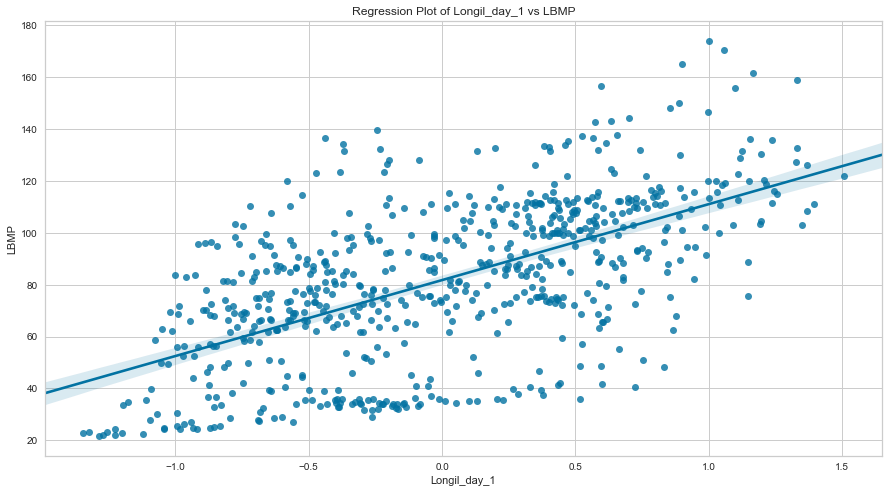

In [46]:
# Regression Plot day vs LBMP
plt.figure(figsize=(15,8))
sns.regplot(X['Longil_1'], Y['LBMP ($/MWHr)'])
plt.title("Regression Plot of Longil_day_1 vs LBMP")
plt.xlabel("Longil_day_1")
plt.ylabel("LBMP")
plt.show()

In [47]:
# create a function that would split data into training and testing
def split_data(features, target):    
    from sklearn.model_selection import train_test_split    
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)    
    return x_train, x_test, y_train, y_test

In [48]:
# A function to evaluate different scores
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
def get_score(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    rmsle = mean_squared_log_error(y_test, y_pred) 
    return (r2, mse, rmse, rmsle)

In [81]:
# function to Plot the Actual vs Predicted 
def plot_data(y_test, y_pred):
    plt.figure(figsize=(18,12))
    plt.plot(y_test.values, label='Actual', c='r')
    plt.plot(y_pred, label='Predicted', c='b')
    plt.title('Actual vs Predicted LBMP')
    plt.ylabel('LBMP')
    plt.legend()

# Bagging Regressor

In [50]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# num of predictors in ensemble is set to 500
# bootstrap = True configures BaggingRegressor to perform Bagging/ bootstrap aggregation
# max_samples=0.8, only 80% of the training data will be used in training each predictor
# oob_score=True, out-of-bag evaluation; 20% of unseen data by each predictor is used to evaluate the same
# n_jobs= -1, # of jobs to run in parallel; -1 means all processes will run in parallel

base_learner = DecisionTreeRegressor()
bagging_model = BaggingRegressor(base_learner, n_estimators=500, bootstrap=True,
                                 max_samples=0.8, oob_score=True, n_jobs=-1)

x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

bagging_model.fit(x_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_sample

In [51]:
y_pred = bagging_model.predict(x_test)

r2, mse, rmse, rmsle = get_score(y_test, y_pred)

print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.923
MSE score of the model is 76.023
RMSE score of the model is 76.023
RMSLE score of the model is 0.009


# Extra Trees
Extremely Randomized (Extra) Trees - adds extra randomness by splitting on random threshold

In [52]:
from sklearn.ensemble import ExtraTreesRegressor

extra_tree_model = ExtraTreesRegressor(n_estimators=500, n_jobs=-1)

x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

extra_tree_model.fit(x_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

In [53]:
y_pred = extra_tree_model.predict(x_test)

r2, mse, rmse, rmsle = get_score(y_test, y_pred)

print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.929
MSE score of the model is 70.582
RMSE score of the model is 70.582
RMSLE score of the model is 0.009


# Random SubSpace

In [54]:
# train using 80% of input features but all data points

rndm_subspace = BaggingRegressor(DecisionTreeRegressor(), bootstrap=False, bootstrap_features=True, n_estimators=500,
                                 max_features=0.8, max_samples=1.0, n_jobs=-1)

x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

rndm_subspace.fit(x_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=False, bootstrap_features=True, max_features=0.8,
                 max_sample

In [55]:
y_pred = rndm_subspace.predict(x_test)

r2, mse, rmse, rmsle = get_score(y_test, y_pred)

print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.914
MSE score of the model is 85.251
RMSE score of the model is 85.251
RMSLE score of the model is 0.015


# Random Forrest

In [56]:
from sklearn.ensemble import RandomForestRegressor

rndm_frst_model = RandomForestRegressor(n_estimators=500, n_jobs=-1)

x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

rndm_frst_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [57]:
y_pred = rndm_frst_model.predict(x_test)

r2, mse, rmse, rmsle = get_score(y_test, y_pred)

print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.933
MSE score of the model is 66.188
RMSE score of the model is 66.188
RMSLE score of the model is 0.008


# Gradient Boosted Regressor

In [58]:
# baseline Gradient Boosted Regressor
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor()
x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])
gbr_model.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
y_pred = gbr_model.predict(x_test)
r2, mse, rmse, rmsle = get_score(y_test, y_pred)
print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.934
MSE score of the model is 65.171
RMSE score of the model is 65.171
RMSLE score of the model is 0.009


## Optimize the hyper parameters by Grid search

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# warm_start = store and reuse previous fit values
# n_iter_no_change = used for early stopping, terminates the training process if validation score 
#is not improving for this many iterations
grb = GradientBoostingRegressor(warm_start=True, n_iter_no_change=15)
x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

num_estimators = [100, 250, 500]
learn_rates = [0.05, 0.1]
depths = [3, 5, None]

# test different values of n_estimators to see which one would yield better results
params = {'n_estimators': num_estimators, 'max_depth': depths, 'learning_rate': learn_rates}

grid_search = GridSearchCV(estimator=grb, param_grid=params, cv=5, return_train_score=True)
#cv = 5 , 5-fold Cross Validation
grid_search.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=15,
                  

In [61]:
# Getting the best hyper parameters
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}

In [62]:
# Print out each parameters 
# total_size = 3*2*3 = 18
for i in range(18):
    print('Parameters:', grid_search.cv_results_['params'][i])
    print('Mean Test Score:', grid_search.cv_results_['mean_test_score'][i])
    print('Rank', grid_search.cv_results_['rank_test_score'][i])

Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Mean Test Score: 0.9196882394839438
Rank 12
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250}
Mean Test Score: 0.928675594639787
Rank 3
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Mean Test Score: 0.927525141833697
Rank 5
Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Mean Test Score: 0.9232255592294426
Rank 11
Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250}
Mean Test Score: 0.9312775132961051
Rank 2
Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}
Mean Test Score: 0.9274943172994154
Rank 6
Parameters: {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 100}
Mean Test Score: 0.8331506100863441
Rank 14
Parameters: {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 250}
Mean Test Score: 0.8045367204602922
Rank 17
Parameters: {'learning_rate': 0.05, 'max_depth': None, 'n_estima

In [63]:
# Gradient Boosting Regressor with Hyperparameters as per Grid Search

hyper_param = grid_search.best_params_

gradient_reg = GradientBoostingRegressor(n_estimators=hyper_param['n_estimators'], max_depth=hyper_param['max_depth'],
                                         learning_rate=hyper_param['learning_rate'])

x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

gradient_reg.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
y_pred = gradient_reg.predict(x_test)

r2, mse, rmse, rmsle = get_score(y_test, y_pred)

print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.943
MSE score of the model is 56.903
RMSE score of the model is 56.903
RMSLE score of the model is 0.008


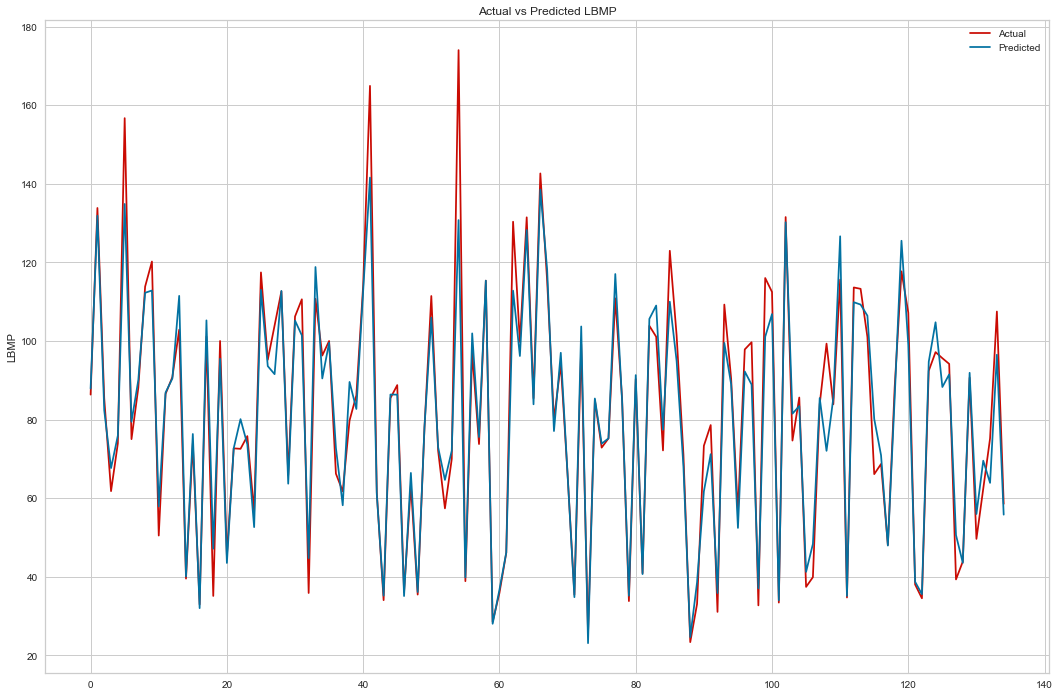

In [82]:
plot_data(y_test, y_pred)

# XGBRegressor

In [66]:
from xgboost import XGBRegressor

baseline_xg = XGBRegressor()

x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

baseline_xg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [67]:
y_pred = baseline_xg.predict(x_test)

r2, mse, rmse, rmsle = get_score(y_test, y_pred)

print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.934
MSE score of the model is 65.685
RMSE score of the model is 65.685
RMSLE score of the model is 0.010


In [68]:
# eval_metric='rmsle' as rmsle has to be minimized

xg_model = XGBRegressor(n_estimators=5000, max_depth=3, learning_rate=0.01, eval_metric='rmsle',
                        colsample_bytree=0.5, alpha=0.5, reg_lambda=0.5, n_jobs=-1, gamma=0.5,
                        subsample=0.5)

x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

xg_model.fit(x_train, y_train)

XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eval_metric='rmsle',
             gamma=0.5, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0.5, reg_lambda=0.5, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
y_pred = xg_model.predict(x_test)
r2, mse, rmse, rmsle = get_score(y_test, y_pred)
print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.3f}')

R2 score of the model is 0.942
MSE score of the model is 57.143
RMSE score of the model is 57.143
RMSLE score of the model is 0.007


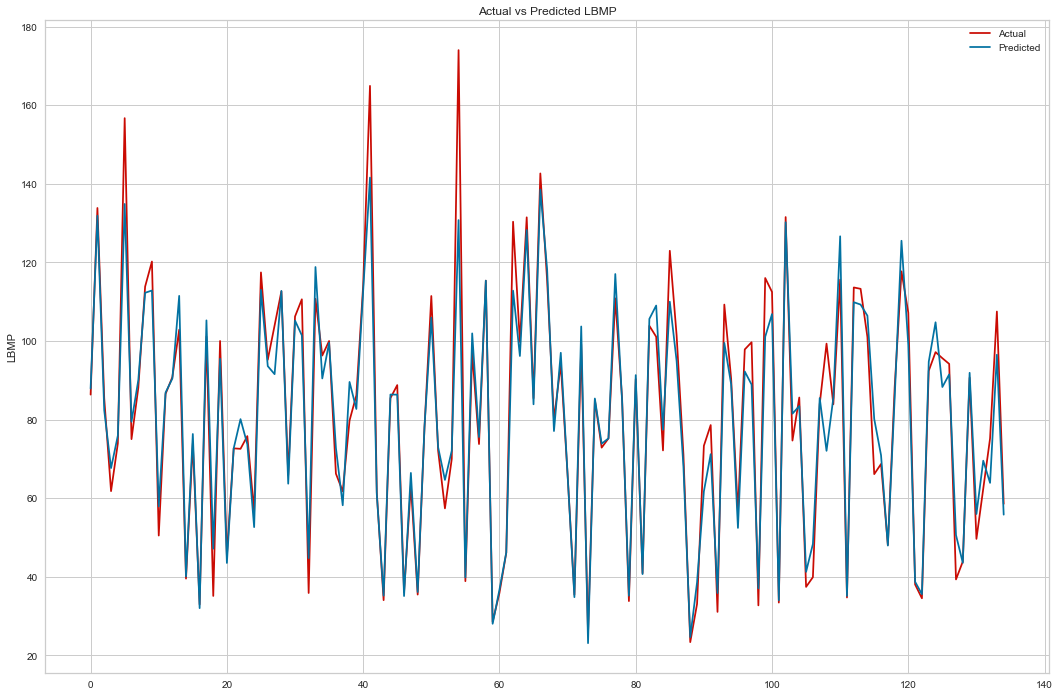

In [83]:
plot_data(y_test, y_pred)

## Now we XGBregressor as our base model and totally 10% of other models

In [71]:
# Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

# Extra Trees Regressor
extra_trees = ExtraTreesRegressor(n_estimators=500, n_jobs=-1)

# Gradient Boosting Regressor
gradient_boosted = GradientBoostingRegressor(n_estimators=5000, loss='huber', learning_rate=0.01, max_depth=3)

# eXtreme Gradient Boosted Regressor
extreme_gradient_boosted = XGBRegressor(n_estimators=5000, max_depth=3, learning_rate=0.01, eval_metric='rmsle',
                        colsample_bytree=0.5, alpha=0.5, reg_lambda=0.5, n_jobs=-1, gamma=0.5,
                        subsample=0.5)

In [72]:
x_train, x_test, y_train, y_test = split_data(X, Y['LBMP ($/MWHr)'])

for model in (random_forest, extra_trees, gradient_boosted, extreme_gradient_boosted):
    model.fit(x_train, y_train)
    print(f'{model.__class__.__name__} has training score of {model.score(x_train, y_train):.3f}')

RandomForestRegressor has training score of 0.990
ExtraTreesRegressor has training score of 1.000
GradientBoostingRegressor has training score of 0.999
XGBRegressor has training score of 1.000


In [73]:
y_pred_rndm_frst = random_forest.predict(x_test)
y_pred_extra_trees = extra_trees.predict(x_test)
y_pred_gbr = gradient_boosted.predict(x_test)
y_pred_xgbr = extreme_gradient_boosted.predict(x_test)

In [74]:
y_final = (0.01*y_pred_rndm_frst + 0.06*y_pred_extra_trees + 0.03*y_pred_gbr + 0.9*y_pred_xgbr)

In [75]:
r2, mse, rmse, rmsle = get_score(y_test, y_final)

print(f'R2 score of the model is {r2:.3f}')
print(f'MSE score of the model is {mse:.3f}')
print(f'RMSE score of the model is {rmse:.3f}')
print(f'RMSLE score of the model is {rmsle:.5f}')

R2 score of the model is 0.943
MSE score of the model is 56.926
RMSE score of the model is 56.926
RMSLE score of the model is 0.00724


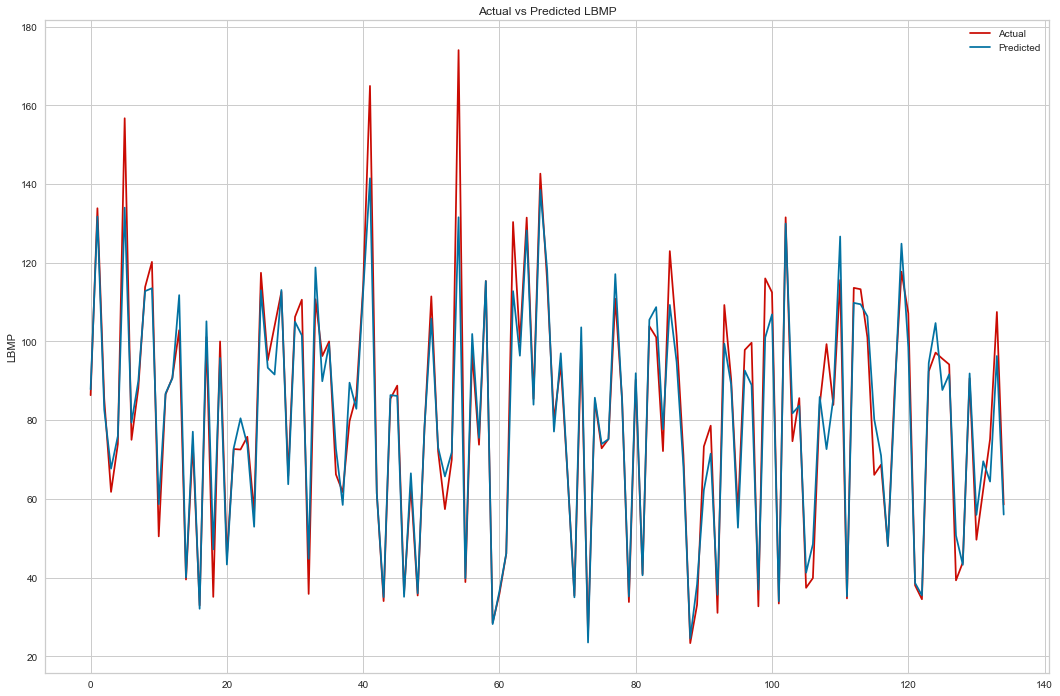

In [84]:
plot_data(y_test, y_final)